### Student Id:Jabez Magomere 91279

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.tabular import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier,GradientBoostingClassifier
from IPython.display import display
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import pylab as plot

params = { 
    'axes.labelsize': "large",
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [10, 6]
}
plot.rcParams.update(params)

In [74]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.ensemble import forest
from sklearn.tree import export_graphviz

def set_plot_sizes(sml, med, big):
    plt.rc('font', size=sml)          # controls default text sizes
    plt.rc('axes', titlesize=sml)     # fontsize of the axes title
    plt.rc('axes', labelsize=med)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=sml)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=sml)    # fontsize of the tick labels
    plt.rc('legend', fontsize=sml)    # legend fontsize
    plt.rc('figure', titlesize=big)  # fontsize of the figure title

def parallel_trees(m, fn, n_jobs=8):
        return list(ProcessPoolExecutor(n_jobs).map(fn, m.estimators_))

def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """ Draws a representation of a random forest in IPython.
    Parameters:
    -----------
    t: The tree you wish to draw
    df: The data used to train the tree. This is used to get the names of the features.
    """
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

def combine_date(years, months=1, days=1, weeks=None, hours=None, minutes=None,
              seconds=None, milliseconds=None, microseconds=None, nanoseconds=None):
    years = np.asarray(years) - 1970
    months = np.asarray(months) - 1
    days = np.asarray(days) - 1
    types = ('<M8[Y]', '<m8[M]', '<m8[D]', '<m8[W]', '<m8[h]',
             '<m8[m]', '<m8[s]', '<m8[ms]', '<m8[us]', '<m8[ns]')
    vals = (years, months, days, weeks, hours, minutes, seconds,
            milliseconds, microseconds, nanoseconds)
    return sum(np.asarray(v, dtype=t) for t, v in zip(types, vals)
               if v is not None)

def get_sample(df,n):
    """ Gets a random sample of n rows from df, without replacement.
    Parameters:
    -----------
    df: A pandas data frame, that you wish to sample from.
    n: The number of rows you wish to sample.
    Returns:
    --------
    return value: A random sample of n rows of df.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    >>> get_sample(df, 2)
       col1 col2
    1     2    b
    2     3    a
    """
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

def add_datepart(df, fldname, drop=True, time=False, errors="raise"):	
    """add_datepart converts a column of df from a datetime64 to many columns containing
    the information from the date. This applies changes inplace.
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    time: If true time features: Hour, Minute, Second will be added.
    Examples:
    ---------
    >>> df = pd.DataFrame({ 'A' : pd.to_datetime(['3/11/2000', '3/12/2000', '3/13/2000'], infer_datetime_format=False) })
    >>> df
        A
    0   2000-03-11
    1   2000-03-12
    2   2000-03-13
    >>> add_datepart(df, 'A')
    >>> df
        AYear AMonth AWeek ADay ADayofweek ADayofyear AIs_month_end AIs_month_start AIs_quarter_end AIs_quarter_start AIs_year_end AIs_year_start AElapsed
    0   2000  3      10    11   5          71         False         False           False           False             False        False          952732800
    1   2000  3      10    12   6          72         False         False           False           False             False        False          952819200
    2   2000  3      11    13   0          73         False         False           False           False             False        False          952905600
    """
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

def is_date(x): return np.issubdtype(x.dtype, np.datetime64)

def train_cats(df):
    """Change any columns of strings in a panda's dataframe to a column of
    categorical values. This applies the changes inplace.
    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category
    """
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

def apply_cats(df, trn):
    """Changes any columns of strings in df into categorical variables using trn as
    a template for the category codes.
    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values. The category codes are determined by trn.
    trn: A pandas dataframe. When creating a category for df, it looks up the
        what the category's code were in trn and makes those the category codes
        for df.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category {a : 1, b : 2}
    >>> df2 = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['b', 'a', 'a']})
    >>> apply_cats(df2, df)
           col1 col2
        0     1    b
        1     2    a
        2     3    a
    now the type of col is category {a : 1, b : 2}
    """
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = c.astype('category').cat.as_ordered()
            df[n].cat.set_categories(trn[n].cat.categories, ordered=True, inplace=True)

def fix_missing(df, col, name, na_dict):
    """ Fill missing data in a column of df with the median, and add a {name}_na column
    which specifies if the data was missing.
    Parameters:
    -----------
    df: The data frame that will be changed.
    col: The column of data to fix by filling in missing data.
    name: The name of the new filled column in df.
    na_dict: A dictionary of values to create na's of and the value to insert. If
        name is not a key of na_dict the median will fill any missing data. Also
        if name is not a key of na_dict and there is no missing data in col, then
        no {name}_na column is not created.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col1'], 'col1', {})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1     2    2    True
    2     3    2   False
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col2'], 'col2', {})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col1'], 'col1', {'col1' : 500})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1   500    2    True
    2     3    2   False
    """
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def numericalize(df, col, name, max_n_cat):
    """ Changes the column col from a categorical type to it's integer codes.
    Parameters:
    -----------
    df: A pandas dataframe. df[name] will be filled with the integer codes from
        col.
    col: The column you wish to change into the categories.
    name: The column name you wish to insert into df. This column will hold the
        integer codes.
    max_n_cat: If col has more categories than max_n_cat it will not change the
        it to its integer codes. If max_n_cat is None, then col will always be
        converted.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> numericalize(df, df['col2'], 'col3', None)
       col1 col2 col3
    0     1    a    1
    1     2    b    2
    2     3    a    1
    """
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1

def scale_vars(df, mapper):
    warnings.filterwarnings('ignore', category=sklearn.exceptions.DataConversionWarning)
    if mapper is None:
        map_f = [([n],StandardScaler()) for n in df.columns if is_numeric_dtype(df[n])]
        mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_names_] = mapper.transform(df)
    return mapper

def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    """ proc_df takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe. For each column of df 
    which is not in skip_flds nor in ignore_flds, na values are replaced by the
    median value of the column.
    Parameters:
    -----------
    df: The data frame you wish to process.
    y_fld: The name of the response variable
    skip_flds: A list of fields that dropped from df.
    ignore_flds: A list of fields that are ignored during processing.
    do_scale: Standardizes each column in df. Takes Boolean Values(True,False)
    na_dict: a dictionary of na columns to add. Na columns are also added if there
        are any missing values.
    preproc_fn: A function that gets applied to df.
    max_n_cat: The maximum number of categories to break into dummy values, instead
        of integer codes.
    subset: Takes a random subset of size subset from df.
    mapper: If do_scale is set as True, the mapper variable
        calculates the values used for scaling of variables during training time (mean and standard deviation).
    Returns:
    --------
    [x, y, nas, mapper(optional)]:
        x: x is the transformed version of df. x will not have the response variable
            and is entirely numeric.
        y: y is the response variable
        nas: returns a dictionary of which nas it created, and the associated median.
        mapper: A DataFrameMapper which stores the mean and standard deviation of the corresponding continuous
        variables which is then used for scaling of during test-time.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> x, y, nas = proc_df(df, 'col1')
    >>> x
       col2
    0     1
    1     2
    2     1
    >>> data = DataFrame(pet=["cat", "dog", "dog", "fish", "cat", "dog", "cat", "fish"],
                 children=[4., 6, 3, 3, 2, 3, 5, 4],
                 salary=[90, 24, 44, 27, 32, 59, 36, 27])
    >>> mapper = DataFrameMapper([(:pet, LabelBinarizer()),
                          ([:children], StandardScaler())])
    >>>round(fit_transform!(mapper, copy(data)), 2)
    8x4 Array{Float64,2}:
    1.0  0.0  0.0   0.21
    0.0  1.0  0.0   1.88
    0.0  1.0  0.0  -0.63
    0.0  0.0  1.0  -0.63
    1.0  0.0  0.0  -1.46
    0.0  1.0  0.0  -0.63
    1.0  0.0  0.0   1.04
    0.0  0.0  1.0   0.21
    """
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

def get_nn_mappers(df, cat_vars, contin_vars):
    # Replace nulls with 0 for continuous, "" for categorical.
    for v in contin_vars: df[v] = df[v].fillna(df[v].max()+100,)
    for v in cat_vars: df[v].fillna('#NA#', inplace=True)

    # list of tuples, containing variable and instance of a transformer for that variable
    # for categoricals, use LabelEncoder to map to integers. For continuous, standardize
    cat_maps = [(o, LabelEncoder()) for o in cat_vars]
    contin_maps = [([o], StandardScaler()) for o in contin_vars]


In [53]:
train_raw = pd.read_csv('titanic_train.csv')
test_raw = pd.read_csv('titanic_test.csv')

In [54]:
#Check the size of the train and test data
train_raw.shape, test_raw.shape

((891, 12), (418, 11))

In [55]:
train_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [56]:
train_raw.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [57]:
#Checking for null values in the data set, it is clear that age has 177 null values
train_raw.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [58]:
#The null age values can be replaced by imputing the median which is more reliable as compared to the mean
#Median hadles outliers
train_raw.Age.median()

28.0

In [59]:
data= train_raw

In [60]:
data['Died'] = 1- data['Survived']

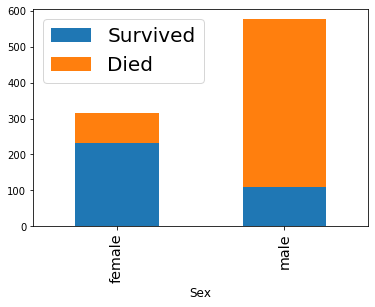

In [61]:
#Visualize survival based on the gender
data.groupby('Sex').agg('sum')[['Survived','Died']].plot(kind='bar',stacked=True)

#### From the plot above it is clear that more males died as compaered to females

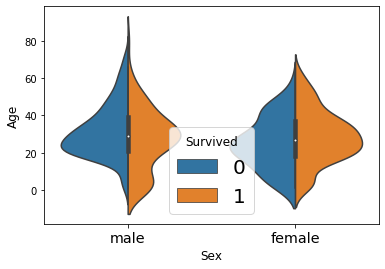

In [62]:
# Correlation of age and survival rate
sns.violinplot(x='Sex',y='Age',hue='Survived', data=data,split=True)

#### A violin plot plays a similar role as a box and whisker plot. It shows the distribution of quantitative data across several levels of one (or more) categorical variables such that those distributions can be compared. Unlike a box plot, in which all of the plot components correspond to actual datapoints, the violin plot features a kernel density estimation of the underlying distribution.

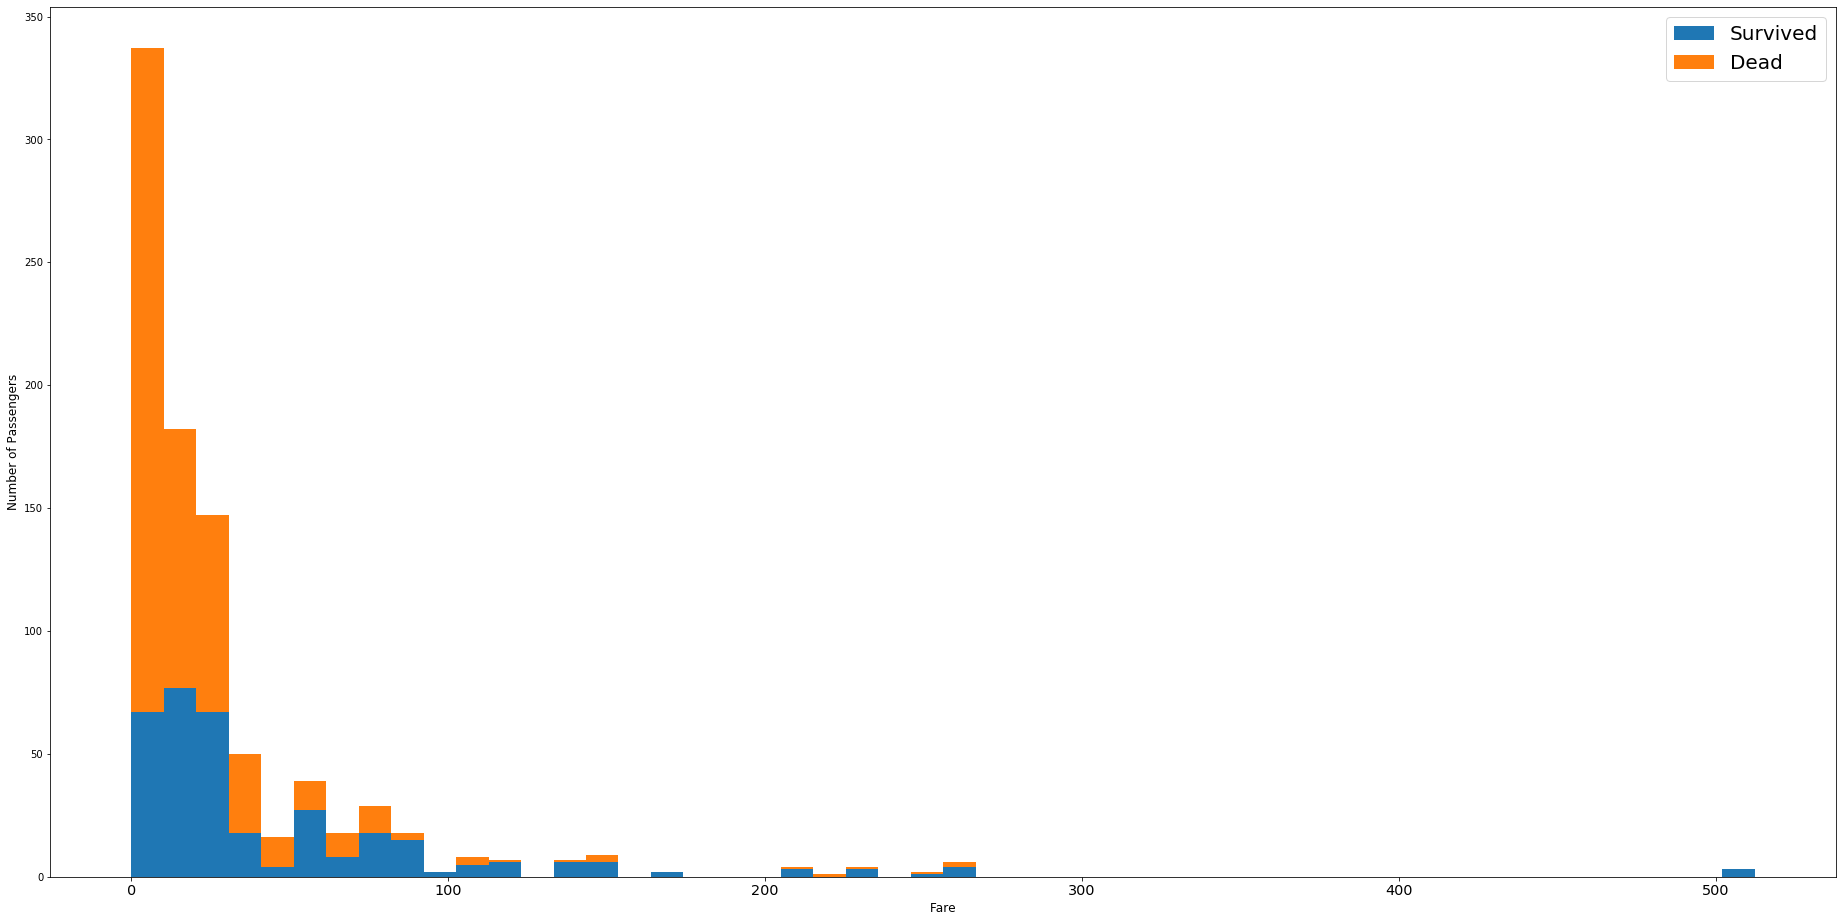

In [63]:
#Check the fare ticket of each passenger and analyse how it impacts the survival
figure = plt.figure(figsize=(32,16))
plt.hist([data[data['Survived'] == 1]['Fare'], data[data['Survived'] == 0]['Fare']], 
         stacked=True,
         bins = 50, label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of Passengers')
plt.legend();

#### It is clear that passengers with cheaper prices are less likely to survive.

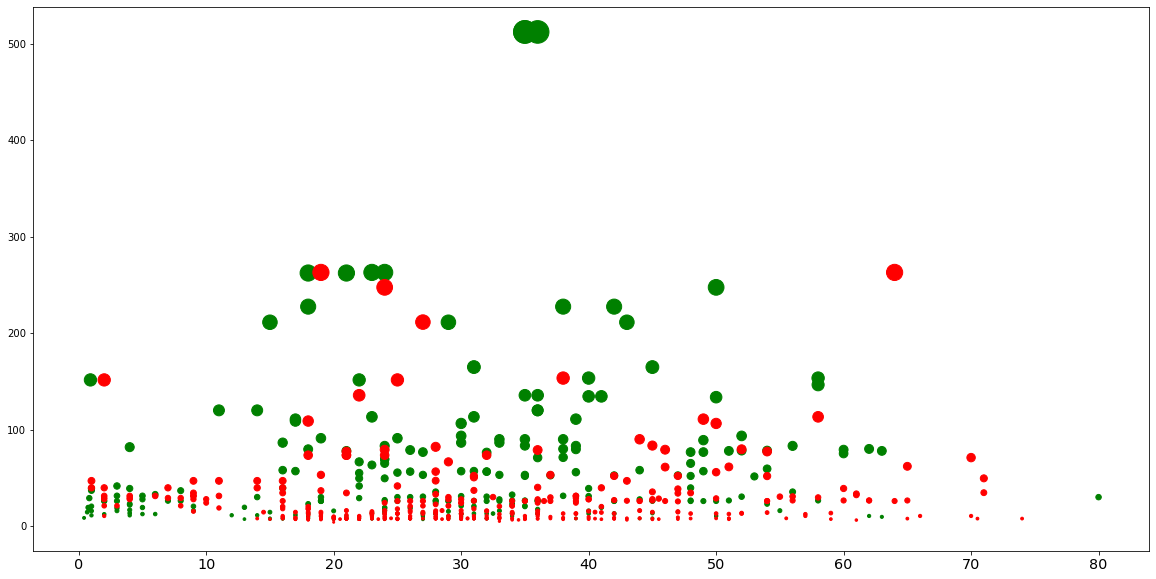

In [64]:
#combining age, fare and survival in one chart.

plt.figure(figsize=(20, 10))
ax = plt.subplot()
ax.scatter(data[data['Survived'] == 1]['Age'], data[data['Survived'] == 1]['Fare'], 
           c='green', s=data[data['Survived'] == 1]['Fare'])
ax.scatter(data[data['Survived'] == 0]['Age'], data[data['Survived'] == 0]['Fare'], 
           c='red', s=data[data['Survived'] == 0]['Fare']);


In [65]:
# ticket fare versus class
data.Pclass.head()

0    3
1    1
2    3
3    1
4    3
Name: Pclass, dtype: int64

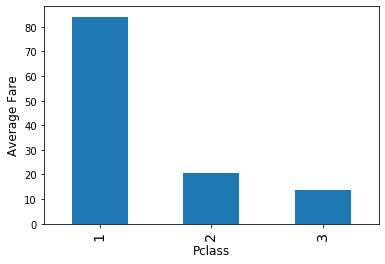

In [66]:
#Group data by Passenger class and compute the mean of ech feature hence obtain the mean fares then plot in a bar chart
ax = plt.subplot()
ax.set_ylabel('Average Fare')
data.groupby('Pclass').mean()['Fare'].plot(kind='bar', ax=ax)

#### It can be concluded that the price hierachy goes from highest in class 1 to lowest in class 3

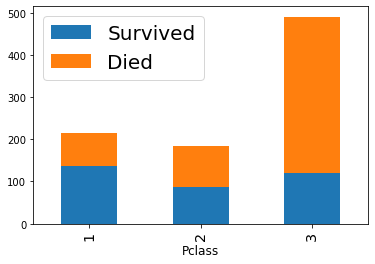

In [67]:
data.groupby('Pclass').agg('sum')[['Survived','Died']].plot(kind='bar',stacked=True)

#### The plot above shows that more people from class 1 survived as compared to the other passenger classes

## Feature Engineering 101

In [68]:
train_raw.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Died
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [69]:
#Combine the test and train data to prepare the data for modelling
#Drop the column containing survived, it is our target variable
x_train = train_raw.drop(['Survived','Died'],1)
y_train = train_raw.Survived
x_test = test_raw

In [70]:
df_combined = x_train.append(x_test,sort=False)
df_combined.shape

(1309, 11)

In [71]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000):
        display(df)

In [72]:
display_all(df_combined.tail().T)

,413,414,415,416,417
PassengerId,1305,1306,1307,1308,1309
Pclass,3,1,3,3,3
Name,"Spector, Mr. Woolf","Oliva y Ocana, Dona. Fermina","Saether, Mr. Simon Sivertsen","Ware, Mr. Frederick","Peter, Master. Michael J"
Sex,male,female,male,male,male
Age,NaN,39,38.5,NaN,NaN
SibSp,0,0,0,0,1
Parch,0,0,0,0,1
Ticket,A.5. 3236,PC 17758,SOTON/O.Q. 3101262,359309,2668
Fare,8.05,108.9,7.25,8.05,22.3583
Cabin,NaN,C105,NaN,NaN,NaN


In [75]:
#train_cats module from fastai, which changes the strings in a dataframe to a 
#categorical values
#This is because machine learning algorithms only understand numerical data

train_cats(df_combined)

In [76]:
display_all(df_combined.tail().T)

,413,414,415,416,417
PassengerId,1305,1306,1307,1308,1309
Pclass,3,1,3,3,3
Name,"Spector, Mr. Woolf","Oliva y Ocana, Dona. Fermina","Saether, Mr. Simon Sivertsen","Ware, Mr. Frederick","Peter, Master. Michael J"
Sex,male,female,male,male,male
Age,NaN,39,38.5,NaN,NaN
SibSp,0,0,0,0,1
Parch,0,0,0,0,1
Ticket,A.5. 3236,PC 17758,SOTON/O.Q. 3101262,359309,2668
Fare,8.05,108.9,7.25,8.05,22.3583
Cabin,NaN,C105,NaN,NaN,NaN


In [77]:
df,y,nas = proc_df(df_combined,y_fld=None,ignore_flds=['Age','Name','Embarked','Cabin','Parch',
                                                      'SibSp'])

In [78]:
df.head()

,Age,Name,Embarked,Cabin,Parch,SibSp,PassengerId,Pclass,Sex,Ticket,Fare,Fare_na
0,22.0,"Braund, Mr. Owen Harris",S,NaN,0,1,1,3,2,721,7.2500,False
1,38.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",C,C85,0,1,2,1,1,817,71.2833,False
2,26.0,"Heikkinen, Miss. Laina",S,NaN,0,0,3,3,1,915,7.9250,False
3,35.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",S,C123,0,1,4,1,1,66,53.1000,False
4,35.0,"Allen, Mr. William Henry",S,NaN,0,0,5,3,2,650,8.0500,False


### Process Family
#### Created some new features(FamilySize, Singleton, Smallfamily, LargeFamily) based on the size of the family. This is under the assumption that large families are usually grouped and support together, hence they are more likely to get rescued than those were travelling alone.

In [79]:
#function to extract a new feature
def process_family():
    
    global df
    # introducing a new feature : the size of families (including the passenger)
    df['FamilySize'] = df['Parch'] + df['SibSp'] + 1
    
    # introducing other features based on the family size
    df['Singleton'] = df['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    df['SmallFamily'] = df['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
    df['LargeFamily'] = df['FamilySize'].map(lambda s: 1 if 5 <= s else 0)    
    return df

In [80]:
df = process_family()

In [81]:
df.tail()

,Age,Name,Embarked,Cabin,Parch,SibSp,PassengerId,Pclass,Sex,Ticket,Fare,Fare_na,FamilySize,Singleton,SmallFamily,LargeFamily
413,NaN,"Spector, Mr. Woolf",S,NaN,0,0,1305,3,2,712,8.0500,False,1,1,0,0
414,39.0,"Oliva y Ocana, Dona. Fermina",C,C105,0,0,1306,1,1,835,108.9000,False,1,1,0,0
415,38.5,"Saether, Mr. Simon Sivertsen",S,NaN,0,0,1307,3,2,873,7.2500,False,1,1,0,0
416,NaN,"Ware, Mr. Frederick",S,NaN,0,0,1308,3,2,580,8.0500,False,1,1,0,0
417,NaN,"Peter, Master. Michael J",C,NaN,1,1,1309,3,2,263,22.3583,False,3,0,1,0


#### Process Embarked
#### Filled the missing embarked with the most frequent one in the train set which is ‘S’ and did a one-hot encoding on the emarked column using the get_dummies method.

In [82]:
def process_embarked():
    global df
    # two missing embarked values - filling them with the most frequent one in the train  set(S)
    df.Embarked.fillna('S', inplace=True)
    # dummy encoding 
    df_dummies = pd.get_dummies(df['Embarked'], prefix='Embarked')
    df = pd.concat([df, df_dummies], axis=1)
    df.drop('Embarked', axis=1, inplace=True)
#     status('embarked')
    return df

In [83]:
df = process_embarked()

In [84]:
df.head()

,Age,Name,Cabin,Parch,SibSp,PassengerId,Pclass,Sex,Ticket,Fare,Fare_na,FamilySize,Singleton,SmallFamily,LargeFamily,Embarked_C,Embarked_Q,Embarked_S
0,22.0,"Braund, Mr. Owen Harris",NaN,0,1,1,3,2,721,7.2500,False,2,0,1,0,0,0,1
1,38.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",C85,0,1,2,1,1,817,71.2833,False,2,0,1,0,1,0,0
2,26.0,"Heikkinen, Miss. Laina",NaN,0,0,3,3,1,915,7.9250,False,1,1,0,0,0,0,1
3,35.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",C123,0,1,4,1,1,66,53.1000,False,2,0,1,0,0,0,1
4,35.0,"Allen, Mr. William Henry",NaN,0,0,5,3,2,650,8.0500,False,1,1,0,0,0,0,1


### Process Cabin
#### Replaced the missing cabins with U (for unknown) and took the first letter of the cabin and did a dummy encoding using get_dummies method.

In [85]:

def process_cabin():
    global df    
    # replacing missing cabins with U (for Uknown)
    df.Cabin.fillna('T', inplace=True)
    
    # mapping each Cabin value with the cabin letter
    df['Cabin'] = df['Cabin'].map(lambda c: c[0])
    
    # dummy encoding ...
    cabin_dummies = pd.get_dummies(df['Cabin'], prefix='Cabin')    
    df = pd.concat([df, cabin_dummies], axis=1)

    df.drop('Cabin', axis=1, inplace=True)
#     status('cabin')
    return df

In [86]:
df = process_cabin()

In [87]:
df.head()

,Age,Name,Parch,SibSp,PassengerId,Pclass,Sex,Ticket,Fare,Fare_na,...,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T
0,22.0,"Braund, Mr. Owen Harris",0,1,1,3,2,721,7.2500,False,...,0,1,0,0,0,0,0,0,0,1
1,38.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,2,1,1,817,71.2833,False,...,0,0,0,0,1,0,0,0,0,0
2,26.0,"Heikkinen, Miss. Laina",0,0,3,3,1,915,7.9250,False,...,0,1,0,0,0,0,0,0,0,1
3,35.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,4,1,1,66,53.1000,False,...,0,1,0,0,1,0,0,0,0,0
4,35.0,"Allen, Mr. William Henry",0,0,5,3,2,650,8.0500,False,...,0,1,0,0,0,0,0,0,0,1


### Get Title from Name
#### Created a new feature ‘Title’ by parsing the name and mapping the titles to the categories defined.

In [88]:
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

def get_titles():
    # we extract the title from each name
    df['Title'] = df['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    
    # a map of more aggregated title
    # we map each title
    df['Title'] = df.Title.map(Title_Dictionary)
#     status('Title')
    return df

In [89]:
df = get_titles()

In [90]:
df.head()

,Age,Name,Parch,SibSp,PassengerId,Pclass,Sex,Ticket,Fare,Fare_na,...,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Title
0,22.0,"Braund, Mr. Owen Harris",0,1,1,3,2,721,7.2500,False,...,1,0,0,0,0,0,0,0,1,Mr
1,38.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,2,1,1,817,71.2833,False,...,0,0,0,1,0,0,0,0,0,Mrs
2,26.0,"Heikkinen, Miss. Laina",0,0,3,3,1,915,7.9250,False,...,1,0,0,0,0,0,0,0,1,Miss
3,35.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,4,1,1,66,53.1000,False,...,1,0,0,1,0,0,0,0,0,Mrs
4,35.0,"Allen, Mr. William Henry",0,0,5,3,2,650,8.0500,False,...,1,0,0,0,0,0,0,0,1,Mr


### Process Age
#### As we have seen earlier Age variable has 177 missing values, which is a huge number out of 891. Just by replacing with the mean/median age might not be the best solution, since the age may differ by group and categories of passengers. Title also can contribute in computing the age. First I took median age grouped by Sex, PassengerClass and Title.

In [91]:
#summarize the Age grouped by sex, class and title
grouped_train = df.groupby(['Sex','Pclass','Title'])
grouped_median_train = grouped_train.median()
grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]

In [92]:
grouped_median_train.head()

,Sex,Pclass,Title,Age
0,1,1,Miss,30.0
1,1,1,Mrs,45.0
2,1,1,Officer,49.0
3,1,1,Royalty,40.5
4,1,2,Miss,20.0


In [93]:
df.head()

,Age,Name,Parch,SibSp,PassengerId,Pclass,Sex,Ticket,Fare,Fare_na,...,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Title
0,22.0,"Braund, Mr. Owen Harris",0,1,1,3,2,721,7.2500,False,...,1,0,0,0,0,0,0,0,1,Mr
1,38.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,2,1,1,817,71.2833,False,...,0,0,0,1,0,0,0,0,0,Mrs
2,26.0,"Heikkinen, Miss. Laina",0,0,3,3,1,915,7.9250,False,...,1,0,0,0,0,0,0,0,1,Miss
3,35.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,4,1,1,66,53.1000,False,...,1,0,0,1,0,0,0,0,0,Mrs
4,35.0,"Allen, Mr. William Henry",0,0,5,3,2,650,8.0500,False,...,1,0,0,0,0,0,0,0,1,Mr


In [94]:

#Assing the value of age for missing values based on the group.
#If a title is miising then the age will be assigned based on sex and class.

def fill_age(row):
    condition = (
        (grouped_median_train['Sex'] == row['Sex']) & 
        (grouped_median_train['Title'] == row['Title']) & 
        (grouped_median_train['Pclass'] == row['Pclass'])
    ) 
    if np.isnan(grouped_median_train[condition]['Age'].values[0]):
        print('true')
        condition = (
            (grouped_median_train['Sex'] == row['Sex']) & 
            (grouped_median_train['Pclass'] == row['Pclass'])
        )

    return grouped_median_train[condition]['Age'].values[0]


def process_age():
    global df
    # a function that fills the missing values of the Age variable
    df['Age'] = df.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
#     status('age')
    return df

In [95]:
df = process_age()

In [96]:
#Check for missing values.

display_all(df.isnull().sum().sort_index()/len(df))

Age            0.000000
Cabin_A        0.000000
Cabin_B        0.000000
Cabin_C        0.000000
Cabin_D        0.000000
Cabin_E        0.000000
Cabin_F        0.000000
Cabin_G        0.000000
Cabin_T        0.000000
Embarked_C     0.000000
Embarked_Q     0.000000
Embarked_S     0.000000
FamilySize     0.000000
Fare           0.000000
Fare_na        0.000000
LargeFamily    0.000000
Name           0.000000
Parch          0.000000
PassengerId    0.000000
Pclass         0.000000
Sex            0.000000
SibSp          0.000000
Singleton      0.000000
SmallFamily    0.000000
Ticket         0.000000
Title          0.000764
dtype: float64

In [97]:
df[df.Title.isnull()]

,Age,Name,Parch,SibSp,PassengerId,Pclass,Sex,Ticket,Fare,Fare_na,...,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Title
414,39.0,"Oliva y Ocana, Dona. Fermina",0,0,1306,1,1,835,108.9,False,...,0,0,0,1,0,0,0,0,0,NaN


### Process Name

In [98]:
# Label encoding the names
def process_names():
    global df
    # we clean the Name variable
    df.drop('Name', axis=1, inplace=True)
    
    # encoding in dummy variable
    titles_dummies = pd.get_dummies(df['Title'], prefix='Title')
    df = pd.concat([df, titles_dummies], axis=1)
    
    # removing the title variable
    df.drop('Title', axis=1, inplace=True)
    
#     status('names')
    return df

In [99]:
df = process_names()

In [100]:
df.head()

,Age,Parch,SibSp,PassengerId,Pclass,Sex,Ticket,Fare,Fare_na,FamilySize,...,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,22.0,0,1,1,3,2,721,7.2500,False,2,...,0,0,0,1,0,0,1,0,0,0
1,38.0,0,1,2,1,1,817,71.2833,False,2,...,0,0,0,0,0,0,0,1,0,0
2,26.0,0,0,3,3,1,915,7.9250,False,1,...,0,0,0,1,0,1,0,0,0,0
3,35.0,0,1,4,1,1,66,53.1000,False,2,...,0,0,0,0,0,0,0,1,0,0
4,35.0,0,0,5,3,2,650,8.0500,False,1,...,0,0,0,1,0,0,1,0,0,0


In [101]:
#Check for existence null values
display_all(df.isnull().sum().sort_index()/len(df))

Age              0.0
Cabin_A          0.0
Cabin_B          0.0
Cabin_C          0.0
Cabin_D          0.0
Cabin_E          0.0
Cabin_F          0.0
Cabin_G          0.0
Cabin_T          0.0
Embarked_C       0.0
Embarked_Q       0.0
Embarked_S       0.0
FamilySize       0.0
Fare             0.0
Fare_na          0.0
LargeFamily      0.0
Parch            0.0
PassengerId      0.0
Pclass           0.0
Sex              0.0
SibSp            0.0
Singleton        0.0
SmallFamily      0.0
Ticket           0.0
Title_Master     0.0
Title_Miss       0.0
Title_Mr         0.0
Title_Mrs        0.0
Title_Officer    0.0
Title_Royalty    0.0
dtype: float64

### Build and train the model

In [102]:
#Seperate out the train & test data

x_train = df[:891].copy()
x_test = df[891:].copy()
x_train.shape,x_test.shape

((891, 30), (418, 30))

In [103]:

#split the tarin data into train and valid set
def split_vals(a,n): return a[:n], a[n:]
valid_count =60
n_trn = len(x_train)-valid_count
x_train1, x_valid1 = split_vals(x_train, n_trn)
y_train1, y_valid1 = split_vals(y_train, n_trn)

In [104]:
x_train1.shape,y_train1.shape,x_valid1.shape,y_valid1.shape


((831, 30), (831,), (60, 30), (60,))

In [105]:
m = RandomForestClassifier(n_estimators=180,min_samples_leaf=3,max_features=0.5,n_jobs=-1)
m.fit(x_train1,y_train1)
m.score(x_train1,y_train1)

0.9386281588447654

### Model Evaluation

In [106]:
y_predict=m.predict(x_valid1)
from sklearn.metrics import accuracy_score
accuracy_score(y_valid1,y_predict)

0.8666666666666667

In [107]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_valid1,y_predict))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89        38
           1       0.82      0.82      0.82        22

    accuracy                           0.87        60
   macro avg       0.86      0.86      0.86        60
weighted avg       0.87      0.87      0.87        60



In [108]:
#confusion Matrix
print(confusion_matrix(y_valid1,y_predict))

[[34  4]
 [ 4 18]]


In [109]:

#Feature importance
fi = rf_feat_importance(m, x_train1); fi[:10]

,cols,imp
26,Title_Mr,0.187486
5,Sex,0.156701
6,Ticket,0.120214
7,Fare,0.094679
3,PassengerId,0.091154
0,Age,0.086472
4,Pclass,0.062885
9,FamilySize,0.030644
12,LargeFamily,0.023405
25,Title_Miss,0.022057


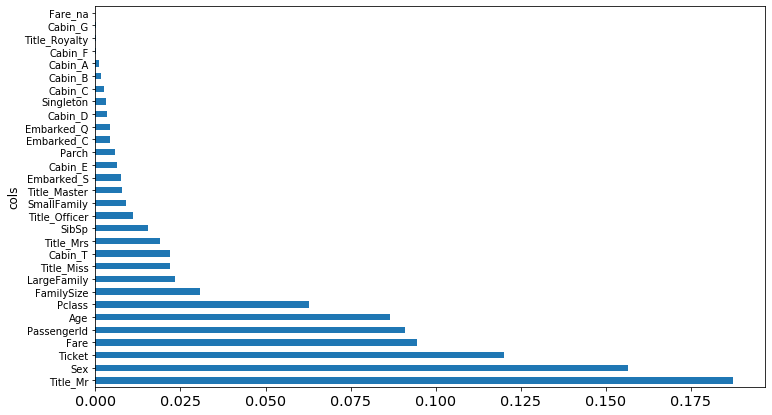

In [110]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:30]);

In [112]:

# Keeping only the variables which are significant for the model(>0.01)
to_keep = fi[fi.imp>0.01].cols; len(to_keep)
to_keep

26         Title_Mr
5               Sex
6            Ticket
7              Fare
3       PassengerId
0               Age
4            Pclass
9        FamilySize
12      LargeFamily
25       Title_Miss
23          Cabin_T
27        Title_Mrs
2             SibSp
28    Title_Officer
Name: cols, dtype: object

In [114]:
#Now training the model on the entire data with only the important features.
x_train = x_train[to_keep]
x_train.head()

,Title_Mr,Sex,Ticket,Fare,PassengerId,Age,Pclass,FamilySize,LargeFamily,Title_Miss,Cabin_T,Title_Mrs,SibSp,Title_Officer
0,1,2,721,7.2500,1,22.0,3,2,0,0,1,0,1,0
1,0,1,817,71.2833,2,38.0,1,2,0,0,0,1,1,0
2,0,1,915,7.9250,3,26.0,3,1,0,1,1,0,0,0
3,0,1,66,53.1000,4,35.0,1,2,0,0,0,1,1,0
4,1,2,650,8.0500,5,35.0,3,1,0,0,1,0,0,0


In [115]:
m = RandomForestClassifier(n_estimators=200,min_samples_leaf=3,max_features=0.5,n_jobs=-1)
m.fit(x_train,y_train)
m.score(x_train,y_train)

0.9304152637485971